## 다중분류(Multiclass classification)
### ex) 뉴스 기사 분류하기
- 리뷰 텍스트를 기반으로 긍/부정 분류
- 참고 : https://github.com/gilbutITbook/006975/blob/master/3.5-classifying-newswires.ipynb

- <b>Reuter 데이터셋</b> :<br>
1986년 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합 데이터로 텍스트 분류를 위해 널리 사용됨

### 1. 데이터셋 로드

In [1]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

# num_words=10000
# : 가장 자주 등장하는 단어 10000개만 사용(드물게 나타나는 단어 무시)

In [2]:
print(len(train_data), len(test_data))

8982 2246


In [3]:
# 데이터셋 텍스트로 디코딩
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [4]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### 2. 데이터 준비

In [5]:
print(train_data[10], '\n')
print(test_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12] 

[1, 361, 372, 8, 77, 62, 325, 4105, 336, 5, 1605, 37, 412, 453, 1187, 229, 334, 13, 4, 867, 76, 4, 76, 1726, 6, 264, 2337, 18, 82, 95, 97, 2220, 4, 1004, 649, 18, 82, 554, 136, 4, 143, 334, 290, 126, 5, 4, 2820, 777, 2, 1386, 13, 954, 7, 4, 314, 912, 224, 4, 2370, 1128, 54, 429, 2, 18, 82, 5, 496, 1187, 229, 57, 85, 385, 593, 6, 4, 867, 76, 17, 12]


In [6]:
# 데이터 : 인코딩
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)   # 훈련데이터 벡터 변환
x_test = vectorize_sequences(test_data)     # 테스트데이터 벡터 변환

In [7]:
print(x_train[10], '\n')
print(x_test[10])

[0. 1. 0. ... 0. 0. 0.] 

[0. 1. 1. ... 0. 0. 0.]


레이블을 벡터로 바꾸는 방법은 1) 레이블 리스트를 정수텐서로 변환하거나, 2) 원-핫 인코딩을 사용하는 방법이 있다. <br>특히
웟-핫 인코딩은 범주형 데이터에 자주 사용된다.

In [8]:
# 레이블 : 원-핫 인코딩
def to_one_hot(labels, dimension=46) :
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels) :
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)   # 훈련레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)     # 테스트레이블 벡터 변환

In [9]:
# 케라스 내장 함수 원-핫 인코딩 방법
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)   # 훈련레이블 벡터 변환
one_hot_test_labels = to_categorical(test_labels)     # 테스트레이블 벡터 변환

### 3. 모델 구성
층의 크기(유닛)은 보통 출력 클래스 개수보다 크게 지정한다. 이번 모델에서는 출력 클래스 개수가 46로 차원이 훨씬 커졌다.

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

마지막 층에는 softmax 활성화 함수가 사용되었다. 각 입력 샘플마다 46개 출력 클래스에 대한 확률 분포를 출력한다.<br>
즉, 46차원(벡터에서 차원은 원소 개수) 출력 벡터를 만든다. output[i]는 어떤 샘플이 클래스 i에 속할 확률로 모두 더하면 1이다.
<br><br>
여기서 최선의 손실함수는 categorical_crossentropy이다. 이는 두 확률분포 사이의 거리를 측정하는 함수로 <br>네트워크가 출력한 확률분포와 진짜 레이블의 분포 사이의 거리다. <br>두 분포 사이의 거리를 최소화하면 진짜 레이블에 가까운 출력을 내도록 모델을 훈련한다.

- 단일 레이블, 다중 분류의 경우 N개의 클래스에 대한 확률 분포를 출력하기 때문에 softmax 활성화 함수를 사용해야 한다.
- 또한, 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 정보 병목이 생기지 않도록 주의해야 한다.

In [11]:
# 모델 컴파일
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

- 다중분류 손실함수(범주형 레이블) : categorical_crossentropy
- 다중분류 손실함수(정수형 레이블) : sparse_categorical_crossentropy

### 4. 훈련 검증

In [12]:
# 검증셋 생성 (1000개 샘플 사용)
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [13]:
# 모델 훈련
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 30ms/step - loss: 2.5849 - accuracy: 0.4979 - val_loss: 1.7149 - val_accuracy: 0.6490
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.3935 - accuracy: 0.7147 - val_loss: 1.2756 - val_accuracy: 0.7190
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.0262 - accuracy: 0.7846 - val_loss: 1.1195 - val_accuracy: 0.7630
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 0.8070 - accuracy: 0.8353 - val_loss: 1.0219 - val_accuracy: 0.7850
Epoch 5/20
16/16 [==============================] - 0s 19ms/step - loss: 0.6496 - accuracy: 0.8658 - val_loss: 0.9602 - val_accuracy: 0.8020
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.5226 - accuracy: 0.8948 - val_loss: 0.9234 - val_accuracy: 0.8050
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.4199 - accuracy: 0.9163 - val_loss: 0.8930 - val_accuracy: 0.8220
Epoch 8/20
16

In [14]:
print(history.history)

{'loss': [2.5849497318267822, 1.3935273885726929, 1.026176929473877, 0.8070107102394104, 0.6495991349220276, 0.5226044654846191, 0.41987934708595276, 0.34574809670448303, 0.2887372672557831, 0.23967710137367249, 0.21457156538963318, 0.18055692315101624, 0.1729513704776764, 0.15232154726982117, 0.14151525497436523, 0.1317775845527649, 0.1291402280330658, 0.1255580335855484, 0.1139349639415741, 0.11369746923446655], 'accuracy': [0.49787020683288574, 0.7147331237792969, 0.7846404314041138, 0.8352543115615845, 0.8658230900764465, 0.8947632312774658, 0.9163116812705994, 0.9288398623466492, 0.934978723526001, 0.944875955581665, 0.9478827118873596, 0.9518917798995972, 0.9528940320014954, 0.9559007883071899, 0.9536457061767578, 0.9576547145843506, 0.9557754993438721, 0.9564018845558167, 0.9586569666862488, 0.9559007883071899], 'val_loss': [1.7149406671524048, 1.2756303548812866, 1.1194977760314941, 1.021852970123291, 0.9601728320121765, 0.9234354496002197, 0.8929969668388367, 0.897200763225555

In [15]:
# 손실 시각화
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

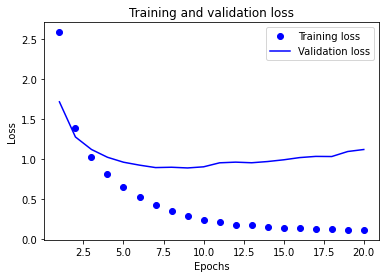

In [16]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

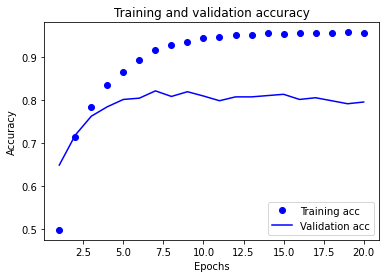

In [18]:
# 정확도 시각화
plt.clf()   # 그래프 초기화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 9번째 에포크 이후 과대적합이 시작된다. val_loss가 증가하며 테스트 정확도가 점점 감소하는 것을 확인할 수 있다.

In [19]:
# 9번 에포크로 새로운 모델 훈련하고 테스트 평가
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 27ms/step - loss: 2.6025 - accuracy: 0.5461 - val_loss: 1.7323 - val_accuracy: 0.6520
Epoch 2/9
16/16 [==============================] - 0s 19ms/step - loss: 1.3800 - accuracy: 0.7169 - val_loss: 1.3052 - val_accuracy: 0.7310
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 1.0156 - accuracy: 0.7879 - val_loss: 1.1425 - val_accuracy: 0.7490
Epoch 4/9
16/16 [==============================] - 0s 18ms/step - loss: 0.7988 - accuracy: 0.8346 - val_loss: 1.0406 - val_accuracy: 0.7780
Epoch 5/9
16/16 [==============================] - 0s 19ms/step - loss: 0.6350 - accuracy: 0.8664 - val_loss: 0.9651 - val_accuracy: 0.8030
Epoch 6/9
16/16 [==============================] - 0s 19ms/step - loss: 0.5144 - accuracy: 0.8906 - val_loss: 0.9474 - val_accuracy: 0.8010
Epoch 7/9
16/16 [==============================] - 0s 19ms/step - loss: 0.4142 - accuracy: 0.9103 - val_loss: 0.9094 - val_accuracy: 0.8170
Epoch 8/9
16/16 [===

In [20]:
results    # 약 79.6% 정확도 달성

[0.9947128295898438, 0.7956367135047913]

### 5. 새로운 데이터 예측

In [21]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [22]:
predictions.shape

(2246, 46)

In [23]:
predictions[0].shape  # 길이가 46인 벡터

(46,)

In [27]:
predictions[0]

array([6.66731576e-05, 3.25471541e-04, 1.76988542e-05, 9.38656509e-01,
       3.10085770e-02, 2.27352197e-04, 9.92964924e-05, 5.44655886e-05,
       2.60383077e-03, 3.31264127e-05, 4.71840991e-04, 9.18181788e-04,
       3.98294884e-04, 1.07441003e-04, 2.11382270e-04, 2.87074545e-05,
       5.25268679e-03, 2.56594445e-04, 1.49510728e-04, 5.82801737e-03,
       6.45404868e-03, 1.32112356e-03, 3.97219083e-05, 5.45179471e-04,
       4.12011923e-06, 3.93085502e-05, 1.23780992e-04, 1.35166965e-05,
       1.71090534e-04, 5.59763925e-04, 6.05752102e-05, 1.84198667e-04,
       3.42115964e-04, 6.39328355e-05, 7.35107678e-05, 6.23364849e-06,
       5.56719780e-04, 6.71965900e-05, 3.28071269e-06, 1.24202797e-03,
       9.54366915e-05, 1.21294230e-03, 1.04317280e-06, 6.59066936e-05,
       6.77697153e-06, 3.07196897e-05], dtype=float32)

In [24]:
np.sum(predictions[0])  # oup 결과 원소의 합은 1

1.0

In [26]:
# argmax : 최대값 색인 위치 출력
np.argmax(predictions[0])  # 가장 확률이 높은 클래스

3

### a. 레이블과 손실을 다루는 다른 방법

In [28]:
# 레이블 인코딩 : 정수텐서로 변환
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [32]:
# 정수텐서를 위한 손실함수 사용
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

위에서 사용한 categorical_crossentropy 는 레이블이 범주형 인코딩 되어 있을때 사용 가능하다.<br>
하지만 범주형이 아닌 정수 레이블을 사용할 때는sparse_categorical_crossentropy 을 사용해야 한다.<br>
인터페이스만 다르고 두 손실함수는 수학적으로 동일하다.

### b. 충분한 중간층의 필요성

마지막 출력이 46차원이기 때문에 중간층의 유닛이 46개보다 많이 적으면 안된다.

In [36]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 2.9447 - accuracy: 0.2402 - val_loss: 2.2847 - val_accuracy: 0.5150
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 1.8875 - accuracy: 0.5669 - val_loss: 1.6833 - val_accuracy: 0.5770
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1.4915 - accuracy: 0.6173 - val_loss: 1.5146 - val_accuracy: 0.6310
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 1.2848 - accuracy: 0.6689 - val_loss: 1.4028 - val_accuracy: 0.6640
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.1275 - accuracy: 0.7010 - val_loss: 1.3410 - val_accuracy: 0.6710
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1.0044 - accuracy: 0.7264 - val_loss: 1.3250 - val_accuracy: 0.6830
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.8985 - accuracy: 0.7725 - val_loss: 1.2774 - val_accuracy: 0.7020
Epoch 8/20
63/63 [=

중간층 유닛을 작게 설정하면 검증정확도는 71%로 약 8% 정도 감소되었다.<br>
이런 손실 원인은 대부분 많은 정보를 적은 중간층의 표현 공간으로 압축하려 했기 때문이다.<br>
즉, 한번에 많은 정보를 압축하려하기 보다는 충분한 중간층을 두는 것이 적절하다.